# Priors on SSFR and MW $Z$ imposed by TNG bases

In [1]:
import os
import numpy as np
import scipy.interpolate as Interp
from astropy.cosmology import Planck13
# -- provabgs --
from provabgs import infer as Infer

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
t_sfh = np.loadtxt('t_sfh.tng6comp.txt')
sfh_bases = np.loadtxt('NMF_basis.sfh.tng6comp.txt', unpack=True)
print('%i components' % sfh_bases.shape[0])

6 components


In [4]:
tcosmo_zh = np.loadtxt('sfh_t_int.txt')
zh_bases = np.loadtxt('NMF_2basis_Z_components_nowgt_lin_Nc2.txt')

In [5]:
_sfh_bases = [
    Interp.InterpolatedUnivariateSpline(t_sfh, sfh_bases[i], k=1)
    for i in range(sfh_bases.shape[0])]

_zh_bases = [ 
    Interp.InterpolatedUnivariateSpline(max(tcosmo_zh) - tcosmo_zh, zh_bases[i], k=1) 
    for i in range(zh_bases.shape[0])]

In [6]:
def sSFH(tt, zred): 
    ''' specific-SFH bases on NMF SFH bases 
    '''
    tt_sfh = np.atleast_2d(tt)[:,:6] # six parameters from Flat Dirichlet Prior

    tage = Planck13.age(zred).value # Gyr
    t = np.linspace(0, tage, 50)
    
    _basis = np.array([_sfh_bases[i](t) / np.trapz(_sfh_bases[i](t), t) for i in range(len(_sfh_bases))])
            # caluclate normalized SFH
    sfh = np.sum(np.array([tt_sfh[:,i][:,None] * _basis[i][None,:] for i in range(len(_sfh_bases))]), axis=0)
    return t, sfh

def avgSSFR(tt, zred, dt=1.): 
    tlookback, sfh = sSFH(tt, zred)
    avsfrs = [] 

    sfh = np.atleast_2d(sfh) / 1e9 # in units of 10^9 Msun 

    tage = tlookback[-1] 
    assert tage > dt # check that the age of the galaxy is longer than the timescale 

    # calculate average SFR over the range tcomic [tage, tage - dt]
    # linearly interpolate SFH at tage - dt  
    i0 = np.where(tlookback < dt)[0][-1]  
    i1 = np.where(tlookback > dt)[0][0]
    
    sfh_t_dt = (sfh[:,i1] - sfh[:,i0]) / (tlookback[i1] - tlookback[i0]) * (dt - tlookback[i0]) + sfh[:,i0]
    _t = np.concatenate([tlookback[:i0+1], [dt]]) 
    _sfh = np.concatenate([sfh[:,:i0+1], sfh_t_dt[:,None]], axis=1)
    return np.trapz(_sfh, _t) / dt

In [7]:
def ZH(tt, zred): 
    ''' ZH
    '''
    tt_zh = tt[:,6:8]
    
    tage = Planck13.age(zred).value
    t = np.linspace(0, tage, 50)
    
    _basis = np.array([_zh_bases[i](t) for i in range(2)])
    zh = np.sum(np.array([tt_zh[:,i][:,None] * _basis[i][None,:] for i in range(2)]), axis=0)
    return t, zh


def Z_MW(tt, zred): 
    ''''''
    tt = np.atleast_2d(tt)
    t, sfh = sSFH(tt, zred)
    _, zh = ZH(tt, zred)
    
    # mass weighted average
    return np.trapz(zh * sfh, t)

In [8]:
prior = Infer.load_priors([
    Infer.FlatDirichletPrior(6), #    Infer.UniformPrior(np.zeros(6), np.ones(6)),
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed') # uniform priors on ZH coeff
])

In [9]:
n_sample = 100000
_thetas = np.array([prior.sample() for i in range(n_sample)])
thetas = prior.transform(_thetas)

In [10]:
ssfr_100myr = avgSSFR(thetas, 0.01, dt=0.1)
ssfr_1gyr = avgSSFR(thetas, 0.01, dt=1.)    
zmw = Z_MW(thetas, 0.01)

In [11]:
print(ssfr_100myr.min(), ssfr_100myr.max())

4.1494101368459834e-13 1.2442509086463537e-09


In [12]:
print(ssfr_1gyr.min(), ssfr_1gyr.max())

4.673076209913957e-13 8.563007744829424e-10


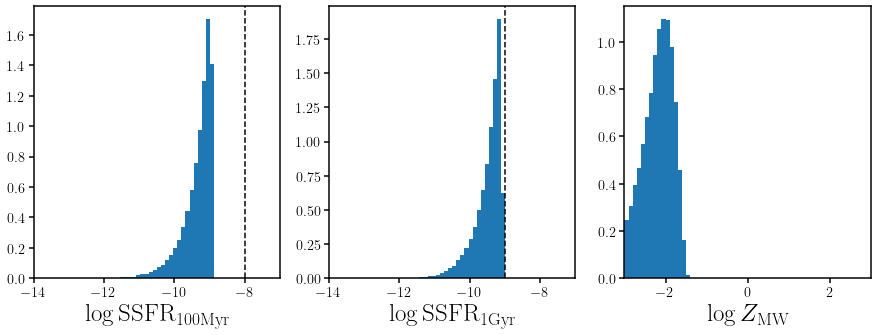

In [13]:
props = [ssfr_100myr, ssfr_1gyr, zmw]
lbls = [r'$\log {\rm SSFR}_{\rm 100 Myr}$', r'$\log {\rm SSFR}_{\rm 1 Gyr}$', r'$\log Z_{\rm MW}$']
rngs = [(-14, -7), (-14, -7), (-3, 3)]

fig = plt.figure(figsize=(15,5))
for i, prop in enumerate(props): 
    sub = fig.add_subplot(1,3,i+1)
    sub.hist(np.log10(np.clip(prop, 1e-13, None)), density=True, range=rngs[i], bins=60)
    if i == 0: sub.axvline(-8., color='k', linestyle='--')
    elif i == 1: sub.axvline(-9., color='k', linestyle='--')
    sub.set_xlabel(lbls[i], fontsize=25)
    sub.set_xlim(rngs[i])

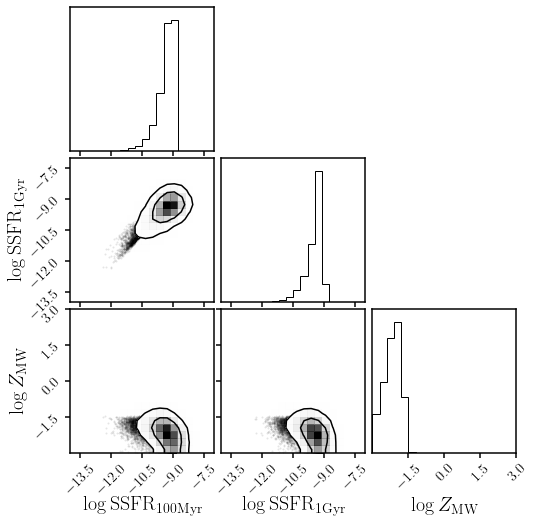

In [14]:
fig = DFM.corner(np.log10(np.array(props).T), 
                     levels=[0.68, 0.95],
                     smooth=True, 
                     range=rngs, 
                     labels=lbls,
                     label_kwargs={'fontsize': 20}
                    )